**Pytorch一般有以下几个流程**


### 1.数据读取

### 2.数据处理

### 3.搭建网络

### 4.模型训练

### 5.模型上线

### 1.数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
torch.__version__

'1.8.1+cu101'

In [2]:
# import tensorflow as tf
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 忽略低级别的警告
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# # The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.8
# # config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)

**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [3]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [4]:
Batch_Size = 64

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=12)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=12)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2. 查看数据（格式，大小，形状）

In [6]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [9]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    
 ### 3. 查看图片

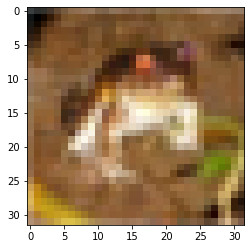

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [11]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

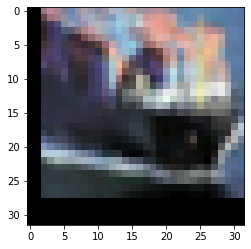

In [12]:
imshow(im[0])

In [13]:
im[0].shape

torch.Size([3, 32, 32])

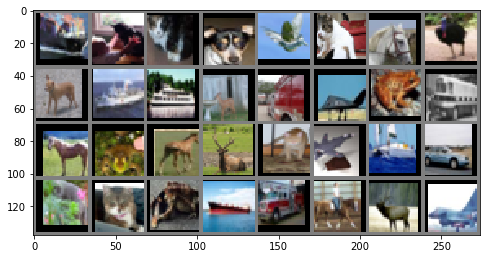

In [14]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

### 4.定义网络（DenseNet）
之前的ResNet通过前层与后层的“短路连接”（Shortcuts），加强了前后层之间的信息流通，在一定程度上缓解了梯度消失现象，从而**可以将神经网络搭建得很深**。更进一步，DenseNet最大化了这种前后层信息交流，通过建立**前面所有层与后面层的密集连接**，实现了特征在通道维度上的复用，使其可以在参数与计算量更少的情况下实现比ResNet更优的性能。如果想详细了解并查看论文，可以看我的另一篇博客[【论文泛读】 DenseNet：稠密连接的卷积网络](https://blog.csdn.net/weixin_45508265/article/details/119069665)

DenseNet 和 ResNet 不同在于 ResNet 是跨层求和，而 DenseNet 是跨层将特征在通道维度进行拼接，下面可以看看他们两者的图示

这个是最标准的卷积神经网络

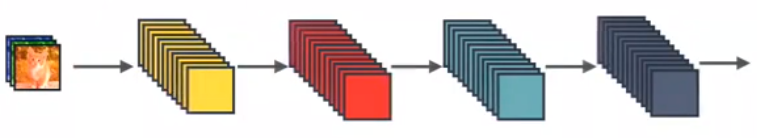

这是ResNet，是跨层求和
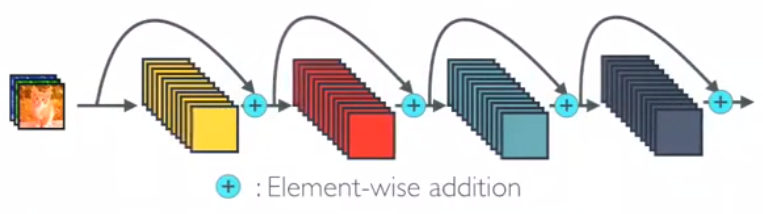

这个就是DenseNet，是跨层将特征在通道维度进行拼接
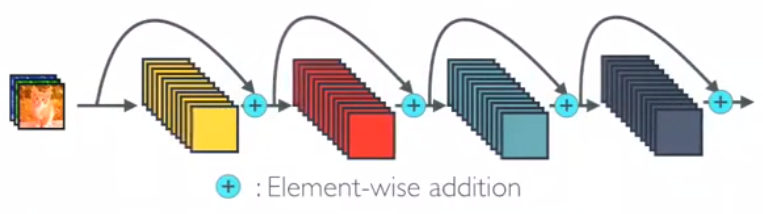

DenseNet的网络架构如下图所示，了便于下采样的实现，我们将网络划分为多个稠密连接的dense block，网络由多个Dense Block与中间的卷积池化组成，核心就在Dense Block中。Dense Block中的黑点代表一个卷积层，其中的多条黑线代表数据的流动，每一层的输入由前面的所有卷积层的输出组成。注意这里使用了通道拼接（Concatnate）操作，而非ResNet的逐元素相加操作。

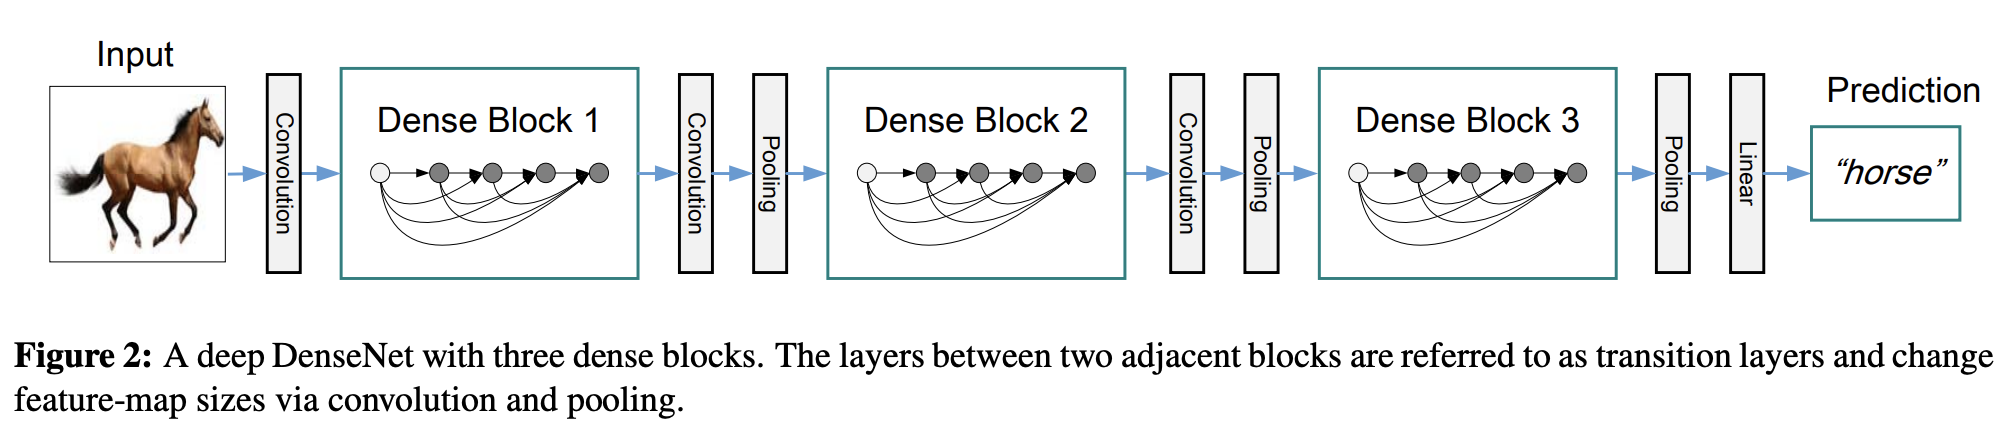


我们将每个block之间的层称为过渡层，完成卷积和池化的操作。在我们的实验中，过渡层由BN层、1x1卷积层和2x2平均池化层组成。



具体的Block实现细节如下图所示，每一个Block由若干个Bottleneck的卷积层组成，对应上面图中的黑点。Bottleneck由BN、ReLU、1×1卷积、BN、ReLU、3×3卷积的顺序构成，也被称为DenseNet-B结构。其中1x1 Conv得到 4k 个特征图它起到的作用是降低特征数量，从而提升计算效率。
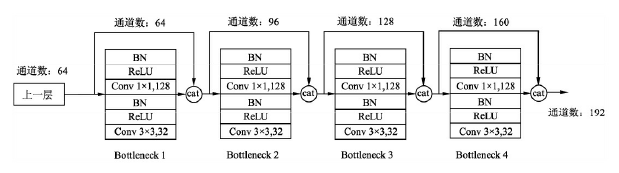


关于Block，有以下4个细节需要注意：

1. 每一个Bottleneck输出的特征通道数是相同的，例如这里的32。同时可以看到，经过Concatnate操作后的通道数是按32的增长量增加的，因此这个32也被称为GrowthRate。
2. 这里1×1卷积的作用是固定输出通道数，达到降维的作用。当几十个Bottleneck相连接时，Concatnate后的通道数会增加到上千，如果不增加1×1的卷积来降维，后续3×3卷积所需的参数量会急剧增加。1×1卷积的通道数通常是GrowthRate的4倍。
3. 上图中的特征传递方式是直接将前面所有层的特征Concatnate后传到下一层，这种方式与具体代码实现的方式是一致的。
4. Block采用了激活函数在前、卷积层在后的顺序，这与一般的网络上是不同的。

![img](.\img\densenet.gif)

### DenseNet 的网络结构

在ImageNet数据集上的网络如下图所示

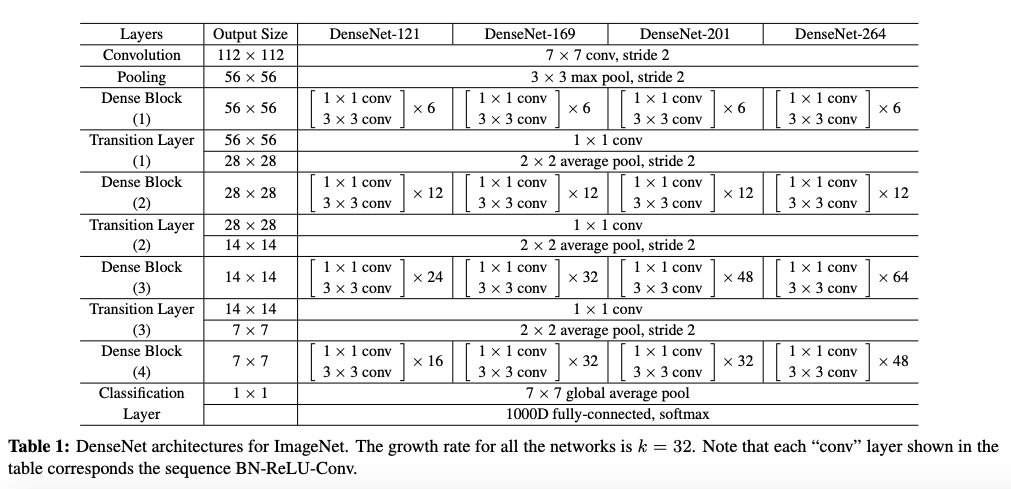

由于我是对CIFAR进行实验，而论文中给出的是ImageNet的网络模型，所以由于数据集的不同，模型稍微有些不同

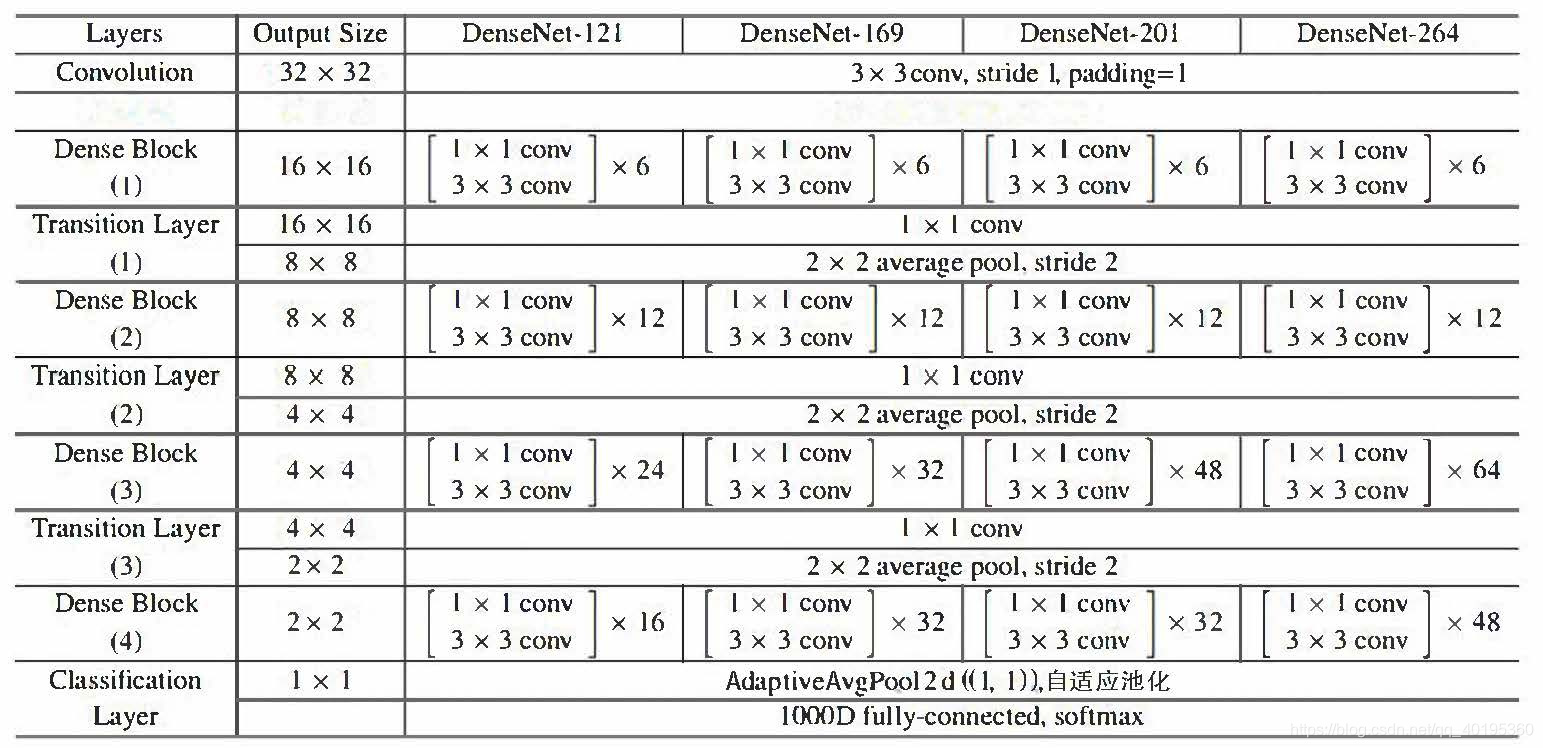

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # 判断是否用GPU
device

'cuda'

#### Bottleneck

In [16]:
class Bottleneck(nn.Module):
    """
    Dense Block
    这里的growth_rate=out_channels, 就是每个Block自己输出的通道数。
    先通过1x1卷积层，将通道数缩小为4 * growth_rate，然后再通过3x3卷积层降低到growth_rate。
    """
    # 通常1×1卷积的通道数为GrowthRate的4倍
    expansion = 4
    
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        zip_channels = self.expansion * growth_rate
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(True),
            nn.Conv2d(zip_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.features(x)
        out = torch.cat([out, x], 1)
        return out        

我们验证一下输出的 channel 是否正确

In [17]:
test_net = Bottleneck(3, 5)
test_x = torch.zeros(1, 3, 32, 32)
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 3 x 32 x 32
output shape: 8 x 32 x 32


#### Transition

In [18]:
class Transition(nn.Module):
    """
    改变维数的Transition层 具体包括BN、ReLU、1×1卷积（Conv）、2×2平均池化操作
    先通过1x1的卷积层减少channels，再通过2x2的平均池化层缩小feature-map
    """
    # 1×1卷积的作用是降维，起到压缩模型的作用，而平均池化则是降低特征图的尺寸。
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(2)
        )
        
    def forward(self, x):
        out = self.features(x)
        return out

验证一下过渡层是否正确

In [19]:
test_net = Transition(3, 12)
test_x = torch.zeros(1, 3, 96, 96)
print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
test_y = test_net(test_x)
print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))

input shape: 3 x 96 x 96
output shape: 12 x 48 x 48


#### DenseNet-BC

In [20]:
# DesneNet-BC
# B 代表 bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
# C 代表压缩系数(0<=theta<=1)
import math
class DenseNet(nn.Module):
    """
    Dense Net
    paper中growth_rate取12，维度压缩的参数θ，即reduction取0.5
    且初始化方法为kaiming_normal()
    num_blocks为每段网络中的DenseBlock数量
    DenseNet和ResNet一样也是六段式网络（一段卷积+四段Dense+平均池化层），最后FC层。
    第一段将维数从3变到2 * growth_rate
    
    (3, 32, 32) -> [Conv2d] -> (24, 32, 32) -> [layer1] -> (48, 16, 16) -> [layer2]
  ->(96, 8, 8) -> [layer3] -> (192, 4, 4) -> [layer4] -> (384, 4, 4) -> [AvgPool]
  ->(384, 1, 1) -> [Linear] -> (10)
    
    """
    def __init__(self, num_blocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.reduction = reduction
        
        num_channels = 2 * growth_rate
        
        self.features = nn.Conv2d(3, num_channels, kernel_size=3, padding=1, bias=False)
        self.layer1, num_channels = self._make_dense_layer(num_channels, num_blocks[0])
        self.layer2, num_channels = self._make_dense_layer(num_channels, num_blocks[1])
        self.layer3, num_channels = self._make_dense_layer(num_channels, num_blocks[2])
        self.layer4, num_channels = self._make_dense_layer(num_channels, num_blocks[3], transition=False)
        self.avg_pool = nn.Sequential(
            nn.BatchNorm2d(num_channels),
            nn.ReLU(True),
            nn.AvgPool2d(4),
        )
        self.classifier = nn.Linear(num_channels, num_classes)
        
        self._initialize_weight()
        
    def _make_dense_layer(self, in_channels, nblock, transition=True):
        layers = []
        for i in range(nblock):
            layers += [Bottleneck(in_channels, self.growth_rate)]
            in_channels += self.growth_rate
        out_channels = in_channels
        if transition:
            out_channels = int(math.floor(in_channels * self.reduction))
            layers += [Transition(in_channels, out_channels)]
        return nn.Sequential(*layers), out_channels
    
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [21]:
def DenseNet121():
    return DenseNet([6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet([6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet([6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet([6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet([6,12,24,16], growth_rate=12)

def densenet_cifar2():
    return DenseNet([6,12,24,16], growth_rate=24)

net = DenseNet121().to(device)

In [22]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]           8,192
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]          36,864
        Bottleneck-8           [-1, 96, 32, 32]               0
       BatchNorm2d-9           [-1, 96, 32, 32]             192
             ReLU-10           [-1, 96, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          12,288
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14           [-1, 32,

In [23]:
print(net)

DenseNet(
  (features): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): 

In [24]:
# 测试
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


In [25]:
net = densenet_cifar2().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True 

### 5. 定义损失函数和优化器 

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
    
损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


In [26]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) # 动态更新学习率
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

import time
epoch = 20

In [27]:
lr = 1e-1
momentum = 0.9
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# 论文原文的batch_size设置为64，epoch为300，在训练到50%和75%的epoch的时候，衰减学习率为原先的1/10
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225])
epoch = 300

### 6. 训练

In [28]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/Denset_improve2.pth'

文件已存在


In [29]:
from utils import train2
from utils import plot_history
Acc, Loss, Lr = train2(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Epoch [  1/300]  Train Loss:1.569999  Train Acc:43.23% Test Loss:1.671141  Test Acc:49.04%  Learning Rate:0.100000	Time 06:39
Epoch [  2/300]  Train Loss:1.016330  Train Acc:64.02% Test Loss:0.894249  Test Acc:68.49%  Learning Rate:0.100000	Time 07:05
Epoch [  3/300]  Train Loss:0.768940  Train Acc:72.99% Test Loss:0.745825  Test Acc:74.46%  Learning Rate:0.100000	Time 06:30
Epoch [  4/300]  Train Loss:0.608702  Train Acc:78.73% Test Loss:0.562613  Test Acc:80.42%  Learning Rate:0.100000	Time 07:00
Epoch [  5/300]  Train Loss:0.522988  Train Acc:81.81% Test Loss:0.587473  Test Acc:79.80%  Learning Rate:0.100000	Time 06:13
Epoch [  6/300]  Train Loss:0.464660  Train Acc:83.93% Test Loss:0.546526  Test Acc:81.69%  Learning Rate:0.100000	Time 06:02
Epoch [  7/300]  Train Loss:0.423940  Train Acc:85.33% Test Loss:0.461083  Test Acc:83.99%  Learning Rate:0.100000	Time 06:02
Epoch [  8/300]  Train Loss:0.393457  Train Acc:86.36% Test Loss:0.491424  Test Acc:83.37%  Learning Rate:0.100000	Tim

Epoch [ 66/300]  Train Loss:0.174476  Train Acc:93.86% Test Loss:0.362599  Test Acc:88.30%  Learning Rate:0.100000	Time 07:43
Epoch [ 67/300]  Train Loss:0.181391  Train Acc:93.69% Test Loss:0.403972  Test Acc:87.32%  Learning Rate:0.100000	Time 07:56
Epoch [ 68/300]  Train Loss:0.176637  Train Acc:93.84% Test Loss:0.334121  Test Acc:88.87%  Learning Rate:0.100000	Time 07:24
Epoch [ 69/300]  Train Loss:0.178090  Train Acc:93.78% Test Loss:0.318009  Test Acc:89.64%  Learning Rate:0.100000	Time 07:10
Epoch [ 70/300]  Train Loss:0.182349  Train Acc:93.62% Test Loss:0.318712  Test Acc:89.44%  Learning Rate:0.100000	Time 06:43
Epoch [ 71/300]  Train Loss:0.176136  Train Acc:93.82% Test Loss:0.405390  Test Acc:87.93%  Learning Rate:0.100000	Time 07:25
Epoch [ 72/300]  Train Loss:0.175637  Train Acc:93.94% Test Loss:0.330509  Test Acc:89.39%  Learning Rate:0.100000	Time 06:30
Epoch [ 73/300]  Train Loss:0.169711  Train Acc:94.02% Test Loss:0.414035  Test Acc:86.79%  Learning Rate:0.100000	Tim

Epoch [131/300]  Train Loss:0.155903  Train Acc:94.56% Test Loss:0.318893  Test Acc:90.02%  Learning Rate:0.100000	Time 06:02
Epoch [132/300]  Train Loss:0.155602  Train Acc:94.69% Test Loss:0.383905  Test Acc:87.94%  Learning Rate:0.100000	Time 06:00
Epoch [133/300]  Train Loss:0.162545  Train Acc:94.33% Test Loss:0.310119  Test Acc:89.76%  Learning Rate:0.100000	Time 06:02
Epoch [134/300]  Train Loss:0.161187  Train Acc:94.47% Test Loss:0.339809  Test Acc:89.03%  Learning Rate:0.100000	Time 06:03
Epoch [135/300]  Train Loss:0.156463  Train Acc:94.52% Test Loss:0.317369  Test Acc:90.01%  Learning Rate:0.100000	Time 06:04
Epoch [136/300]  Train Loss:0.153608  Train Acc:94.47% Test Loss:0.336127  Test Acc:89.22%  Learning Rate:0.100000	Time 06:02
Epoch [137/300]  Train Loss:0.160865  Train Acc:94.38% Test Loss:0.307050  Test Acc:89.95%  Learning Rate:0.100000	Time 06:02
Epoch [138/300]  Train Loss:0.153806  Train Acc:94.79% Test Loss:0.328854  Test Acc:89.04%  Learning Rate:0.100000	Tim

Epoch [196/300]  Train Loss:0.003218  Train Acc:99.93% Test Loss:0.215856  Test Acc:94.96%  Learning Rate:0.010000	Time 06:27
Epoch [197/300]  Train Loss:0.003398  Train Acc:99.91% Test Loss:0.214336  Test Acc:94.93%  Learning Rate:0.010000	Time 06:32
Epoch [198/300]  Train Loss:0.003044  Train Acc:99.93% Test Loss:0.216641  Test Acc:94.90%  Learning Rate:0.010000	Time 06:28
Epoch [199/300]  Train Loss:0.003352  Train Acc:99.93% Test Loss:0.205136  Test Acc:95.21%  Learning Rate:0.010000	Time 06:34
Epoch [200/300]  Train Loss:0.003934  Train Acc:99.92% Test Loss:0.228520  Test Acc:94.84%  Learning Rate:0.010000	Time 06:33
Epoch [201/300]  Train Loss:0.003658  Train Acc:99.92% Test Loss:0.217242  Test Acc:94.68%  Learning Rate:0.010000	Time 06:26
Epoch [202/300]  Train Loss:0.005612  Train Acc:99.85% Test Loss:0.216836  Test Acc:94.82%  Learning Rate:0.010000	Time 06:21
Epoch [203/300]  Train Loss:0.003711  Train Acc:99.90% Test Loss:0.224193  Test Acc:94.68%  Learning Rate:0.010000	Tim

Epoch [261/300]  Train Loss:0.001127  Train Acc:99.98% Test Loss:0.221245  Test Acc:95.07%  Learning Rate:0.001000	Time 06:19
Epoch [262/300]  Train Loss:0.001016  Train Acc:99.99% Test Loss:0.224365  Test Acc:94.98%  Learning Rate:0.001000	Time 06:16
Epoch [263/300]  Train Loss:0.000891  Train Acc:100.00% Test Loss:0.215764  Test Acc:95.14%  Learning Rate:0.001000	Time 06:15
Epoch [264/300]  Train Loss:0.000962  Train Acc:99.99% Test Loss:0.222116  Test Acc:95.05%  Learning Rate:0.001000	Time 06:15
Epoch [265/300]  Train Loss:0.001139  Train Acc:99.98% Test Loss:0.209084  Test Acc:95.28%  Learning Rate:0.001000	Time 06:18
Epoch [266/300]  Train Loss:0.000964  Train Acc:99.99% Test Loss:0.208681  Test Acc:95.21%  Learning Rate:0.001000	Time 06:17
Epoch [267/300]  Train Loss:0.001182  Train Acc:99.98% Test Loss:0.212586  Test Acc:95.29%  Learning Rate:0.001000	Time 06:18
Epoch [268/300]  Train Loss:0.001047  Train Acc:99.99% Test Loss:0.220652  Test Acc:95.25%  Learning Rate:0.001000	Ti

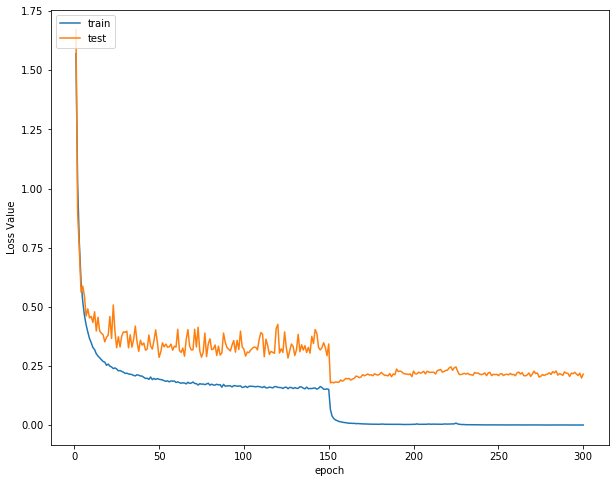

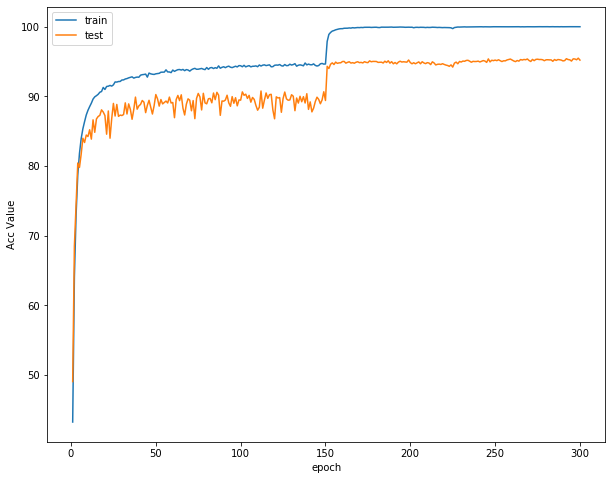

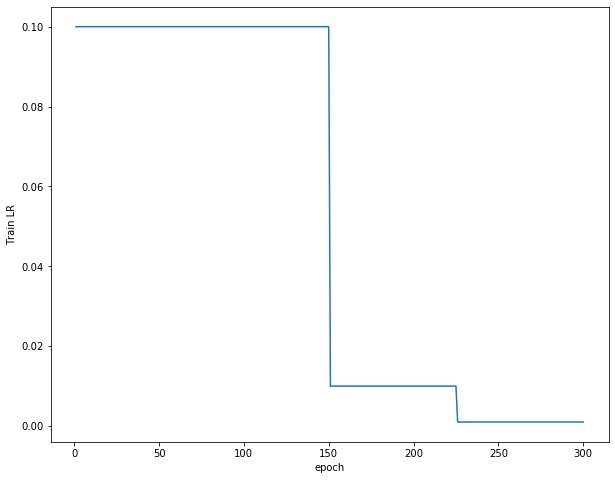

In [30]:
plot_history(epoch ,Acc, Loss, Lr)

### 7.测试

In [31]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader:  # 循环每一个batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval()  # 把模型转为test模式
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)  # 输入网络进行测试

        # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)          # 更新测试图片的数量
        correct += (predicted == labels).sum() # 更新正确分类的图片的数量

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 95.36 %


In [32]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 95.80 %
Accuracy of automobile : 97.00 %
Accuracy of  bird : 94.90 %
Accuracy of   cat : 88.40 %
Accuracy of  deer : 96.40 %
Accuracy of   dog : 92.50 %
Accuracy of  frog : 97.30 %
Accuracy of horse : 96.90 %
Accuracy of  ship : 96.80 %
Accuracy of truck : 95.80 %


Accuracy Rate = 98.4375%


<Figure size 1800x288 with 0 Axes>

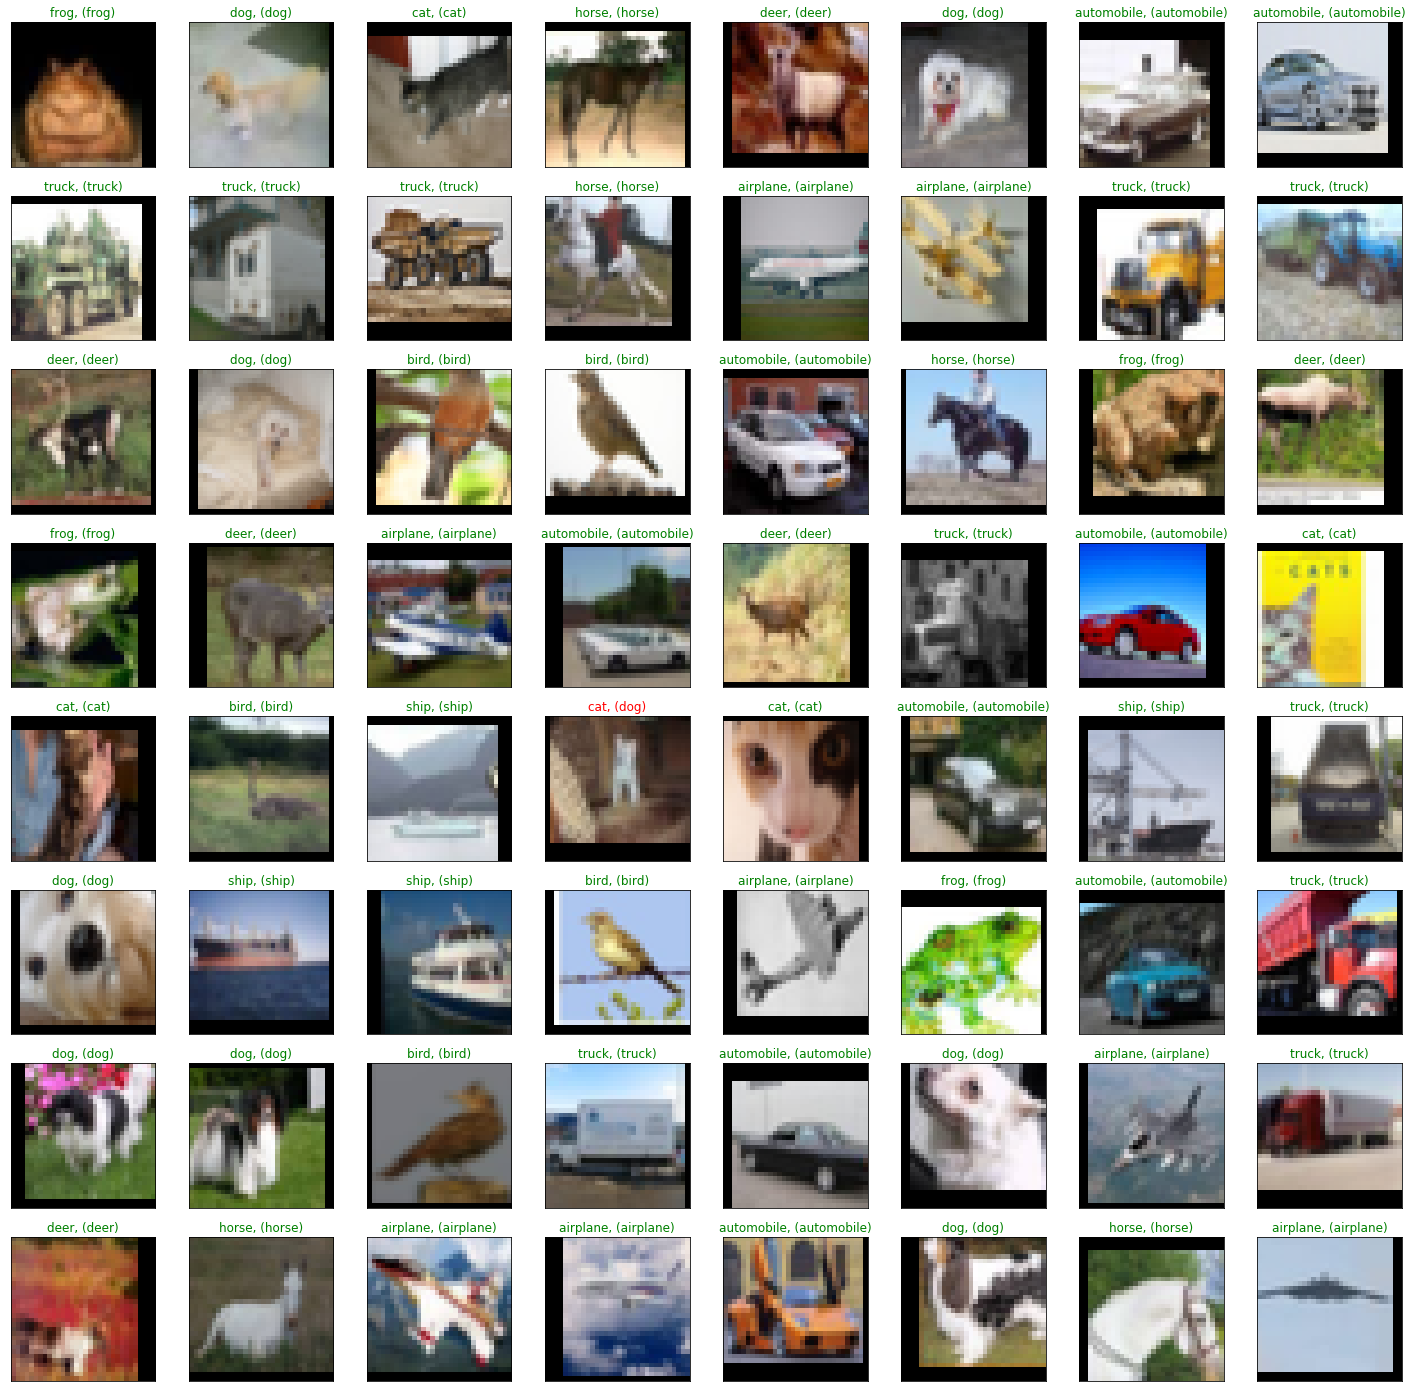

In [33]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()


print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

### 8. 保存模型

In [34]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')
# torch.save(net, './model/ResNet50.pth')

### 9. 预测

In [35]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = densenet_cifar2()

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

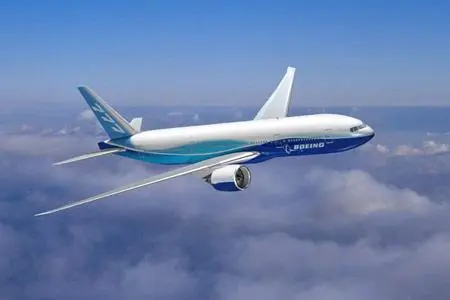

In [36]:
img

In [37]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

c:\users\86137\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


概率 tensor([[9.9999e-01, 1.2426e-06, 5.2505e-07, 2.0353e-07, 3.2023e-06, 1.8266e-06,
         6.3465e-08, 1.5295e-07, 1.2121e-06, 3.5105e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
类别 0
tensor([13.0082], device='cuda:0')
分类 plane


<Response [200]>


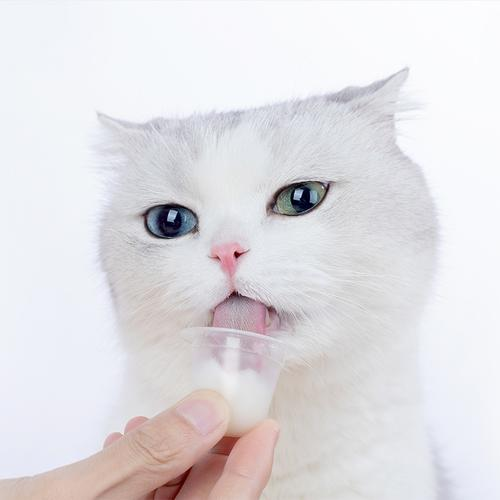

In [38]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [39]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[5.6606e-05, 1.1493e-06, 5.0711e-06, 9.9992e-01, 2.8735e-07, 8.2337e-06,
         2.5398e-06, 1.6778e-06, 1.1239e-06, 9.8141e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
类别 3
tensor([11.6132], device='cuda:0')
分类 cat


c:\users\86137\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
